In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stat

pd.set_option('display.max_columns', 500)
%matplotlib inline

In [241]:
pts = pd.read_csv('eicu-collaborative-research-database-2.0/patient.csv.gz')
dxs = pd.read_csv('eicu-collaborative-research-database-2.0/diagnosis.csv.gz')
tm = pd.read_csv('eicu-collaborative-research-database-2.0/treatment.csv.gz')
hos = pd.read_csv('eicu-collaborative-research-database-2.0/hospital.csv.gz')
cpg = pd.read_csv('eicu-collaborative-research-database-2.0/carePlanGeneral.csv.gz')

#### Cleaning the data and adding features

In [242]:
# patients that were given pain meds
tm['painmeds'] = tm['treatmentstring'].str.contains('analgesics', case = False)
tm = tm[tm.painmeds == True]

tm.drop_duplicates(subset='patientunitstayid', inplace=True)
tm.drop(['treatmentid','treatmentoffset', 'activeupondischarge'], axis=1, inplace=True)

In [243]:
pts = pd.merge(pts, tm, on=['patientunitstayid'], how = 'left')
pts = pd.merge(pts, hos, on=['hospitalid'], how = 'left')

In [244]:
pts['treatmentstring'].fillna('no pain medications', inplace= True)
pts['painmeds'].fillna(False, inplace=True)

In [245]:
def age (x):
    if x == '> 89':
        return 90
    else:
        return int(x)
    
def pain_val (x, arr):
    try:
        return round(arr['nursingchartvalue'][x])
    except:
        return np.nan

In [246]:
pts = pts[pts.gender != 'Unknown']
pts = pts[pts.gender != 'Other']

In [247]:
pts['apacheadmissiondx'].fillna(value = 'N/A', inplace = True)
pts['hospitaladmitsource'].fillna(value = 'Unknown', inplace = True)

pts['age'].fillna(value = 0, inplace = True)
pts['age'] = pts['age'].apply(lambda x: age(x))

In [248]:
pts['hospitaladmittime24'] = pts['hospitaladmittime24'].apply(lambda x: x[0:2])
pts['hospitaldischargetime24'] = pts['hospitaldischargetime24'].apply(lambda x: x[0:2])
pts['unitadmittime24'] = pts['unitadmittime24'].apply(lambda x: x[0:2])
pts['unitdischargetime24'] = pts['unitdischargetime24'].apply(lambda x: x[0:2])

In [ ]:
nsc = pd.read_csv('eicu-collaborative-research-database-2.0/nurseCharting.csv.gz')

In [11]:
# adding pain scores
nsc.drop(['nursingchartid', 'nursingchartoffset', 
          'nursingchartcelltypecat', 'nursingchartcelltypevallabel'], axis=1, inplace=True)
nsc = nsc[nsc['nursingchartcelltypevalname'] == 'Pain Score']

In [12]:
valid = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]

nsc['nursingchartvalue'] = nsc['nursingchartvalue'].apply(lambda x: float(x))
nsc = nsc[nsc['nursingchartvalue'].isin(valid)]

nsc['nursingchartvalue'] = nsc['nursingchartvalue'].apply(lambda x: int(x))
nsc.drop(['nursingchartcelltypevalname'], axis=1, inplace=True)

In [13]:
max_pain = nsc.groupby('patientunitstayid').max()
mean_pain = nsc.groupby('patientunitstayid').mean()

In [249]:
pts['max_pain'] = pts['patientunitstayid'].apply(lambda x: pain_val(x, max_pain))
pts['mean_pain'] = pts['patientunitstayid'].apply(lambda x: pain_val(x, mean_pain))

In [250]:
# adding icd9 codes
dxs = dxs.drop(columns=['diagnosisid', 'activeupondischarge', 'diagnosisoffset', 'diagnosisstring'])
dxs.dropna(inplace=True)

# merge
dxs = dxs.groupby('patientunitstayid')['icd9code'].apply(list).reset_index(name='icd9codes')
pts = pd.merge(pts, dxs, on=['patientunitstayid'], how='left')

In [251]:
# adding ordered protocols
cpg = cpg[cpg.cplgroup == 'Ordered Protocols']
cpg.drop(columns=['cplgeneralid', 'activeupondischarge', 'cplitemoffset', 'cplgroup'], inplace = True)
cpg.drop_duplicates(inplace=True)

# merge
cpg = cpg.groupby('patientunitstayid')['cplitemvalue'].apply(list).reset_index(name='orderedprotocols')
pts = pd.merge(pts, cpg, on=['patientunitstayid'], how = 'left')

In [252]:
pts['max_pain'].fillna(value=round(pts['max_pain'].mean(skipna=True)), inplace = True)
pts['mean_pain'].fillna(value=round(pts['mean_pain'].mean(skipna=True)), inplace = True)

In [253]:
pts = pts.drop(columns=['hospitaladmittime24', 'hospitaldischargeyear', 'hospitaldischargetime24',
                       'unitadmittime24', 'dischargeweight', 'unitdischargetime24', 'uniquepid'])

In [254]:
pts = pts.dropna(axis = 0)

In [255]:
pts.head()

,patientunitstayid,patienthealthsystemstayid,gender,age,ethnicity,hospitalid,wardid,apacheadmissiondx,admissionheight,hospitaladmitoffset,hospitaladmitsource,hospitaldischargeoffset,hospitaldischargelocation,hospitaldischargestatus,unittype,unitadmitsource,unitvisitnumber,unitstaytype,admissionweight,unitdischargeoffset,unitdischargelocation,unitdischargestatus,treatmentstring,painmeds,numbedscategory,teachingstatus,region,max_pain,mean_pain,icd9codes,orderedprotocols
2338,156771,140989,Female,88,Caucasian,63,95,"CVA, cerebrovascular accident/stroke",152.4,-14,Direct Admit,14457,Skilled Nursing Facility,Alive,Med-Surg ICU,Direct Admit,1,admit,64.6,724,Floor,Alive,no pain medications,False,100 - 249,f,Midwest,8.0,3.0,"[585.9, N18.9, 434.91, I63.50, 401.9, I10]",[Tissue Plasminogen Activator (tPA)]
10375,211851,183825,Female,48,Caucasian,59,91,"Thrombosis, vascular (deep vein)",170.2,-1561,Emergency Department,4064,Home,Alive,Med-Surg ICU,Floor,1,admit,68.4,2331,Floor,Alive,no pain medications,False,<100,f,Midwest,6.0,3.0,"[451.2, I80.3]",[Tissue Plasminogen Activator (tPA)]
12087,222815,192329,Female,68,Caucasian,73,89,"CVA, cerebrovascular accident/stroke",160.0,-71,Direct Admit,9514,Skilled Nursing Facility,Alive,Neuro ICU,Direct Admit,1,admit,90.8,2824,Floor,Alive,no pain medications,False,>= 500,t,Midwest,0.0,0.0,"[434.91, I63.50]",[Tissue Plasminogen Activator (tPA)]
12952,228110,196429,Male,64,Caucasian,58,108,"Infarction, acute myocardial (MI)",165.1,-114,Emergency Department,2605,Home,Alive,Med-Surg ICU,Emergency Department,1,admit,92.5,1129,Step-Down Unit (SDU),Alive,no pain medications,False,100 - 249,f,Midwest,4.0,1.0,"[786.50, R07.9, 410.71, I21.4]",[Other]
14989,242319,207482,Male,61,Caucasian,79,133,"Sepsis, other",172.7,0,Direct Admit,5896,Home,Alive,Med-Surg ICU,Direct Admit,1,admit,60.6,1856,Floor,Alive,neurologic|pain / agitation / altered mentatio...,True,>= 500,f,Midwest,6.0,2.0,"[038.9, A41.9, 205.00, C92.00, 458.9, I95.9, 4...",[Sepsis bundle]


#### Figures

Text(0, 0.5, '% of Receiving Pain Medications')

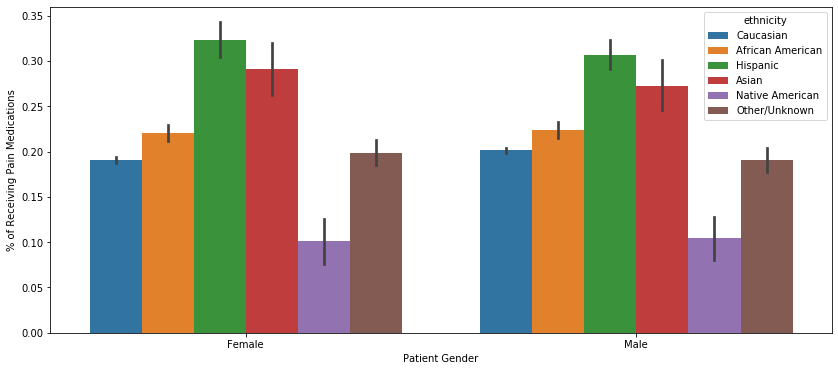

In [21]:
plt.figure(figsize=(14, 6))
sns.barplot(x='gender',y='painmeds',hue='ethnicity',data=pts, estimator=np.mean)
plt.xlabel('Patient Gender')
plt.ylabel('% of Receiving Pain Medications')

Text(0, 0.5, 'Average Pain Score')

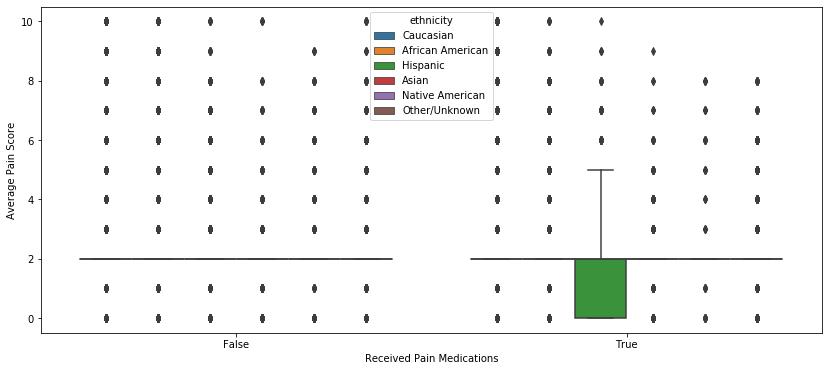

In [22]:
# must render before imputing mean and max pain values
plt.figure(figsize=(14, 6))
sns.boxplot(x='painmeds',y='mean_pain',hue='ethnicity',data=pts)
plt.xlabel('Received Pain Medications')
plt.ylabel('Average Pain Score')

Text(0, 0.5, 'Pain Medications')

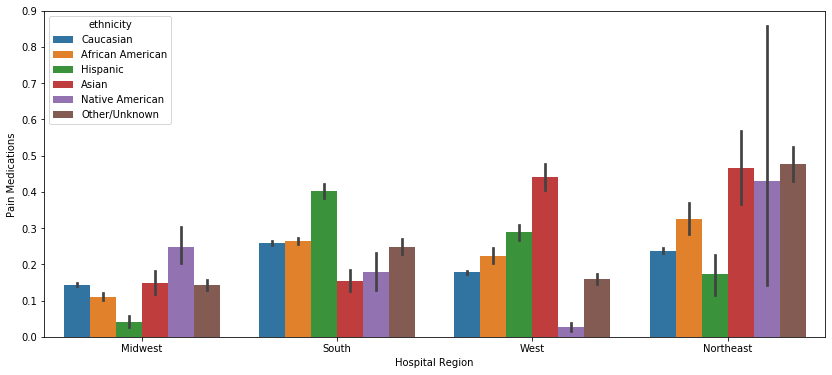

In [23]:
plt.figure(figsize=(14, 6))
sns.barplot(x='region', y='painmeds', hue='ethnicity', data=pts, estimator=np.mean)
plt.xlabel('Hospital Region')
plt.ylabel('Pain Medications')

Text(0, 0.5, 'Average Pain Score per Patient')

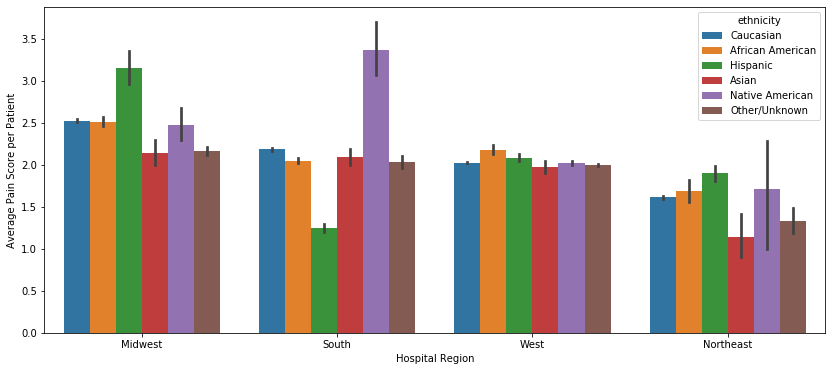

In [24]:
plt.figure(figsize=(14, 6))
sns.barplot(x='region', y='mean_pain', hue='ethnicity', data=pts, estimator=np.mean)
plt.xlabel('Hospital Region')
plt.ylabel('Average Pain Score per Patient')

Text(0, 0.5, 'Average Maximum Pain Score per Patient')

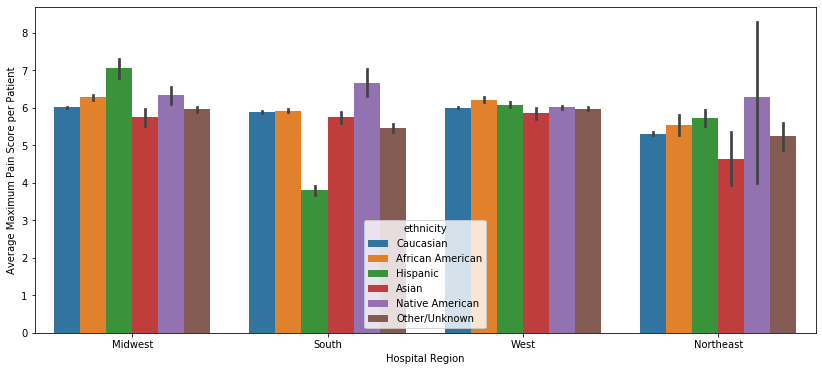

In [25]:
plt.figure(figsize=(14, 6))
sns.barplot(x='region', y='max_pain', hue='ethnicity', data=pts, estimator=np.mean)
plt.xlabel('Hospital Region')
plt.ylabel('Average Maximum Pain Score per Patient')

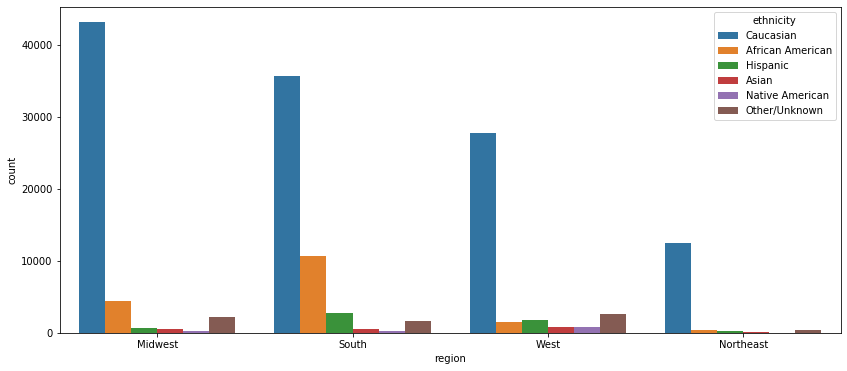

In [26]:
plt.figure(figsize=(14, 6))
sns.countplot(x='region', hue='ethnicity', data=pts)

___
#### Gradient Boosting Classifier

In [257]:
pts.columns

Index(['patientunitstayid', 'patienthealthsystemstayid', 'gender', 'age',
       'ethnicity', 'hospitalid', 'wardid', 'apacheadmissiondx',
       'admissionheight', 'hospitaladmitoffset', 'hospitaladmitsource',
       'hospitaldischargeoffset', 'hospitaldischargelocation',
       'hospitaldischargestatus', 'unittype', 'unitadmitsource',
       'unitvisitnumber', 'unitstaytype', 'admissionweight',
       'unitdischargeoffset', 'unitdischargelocation', 'unitdischargestatus',
       'treatmentstring', 'painmeds', 'numbedscategory', 'teachingstatus',
       'region', 'max_pain', 'mean_pain', 'icd9codes', 'orderedprotocols'],
      dtype='object')

In [62]:
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc

In [275]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

# one hot ecoding

pts = pts.join(pd.DataFrame(mlb.fit_transform(pts.pop('orderedprotocols')), columns=mlb.classes_, index=pts.index))
pts = pts.join(pd.DataFrame(mlb.fit_transform(pts.pop('icd9codes')), columns=mlb.classes_, index=pts.index))

In [276]:
cat_cols = ['gender', 'ethnicity', 'hospitalid', 'wardid', 'apacheadmissiondx', 'hospitaladmitsource', 
            'hospitaldischargelocation', 'hospitaldischargestatus', 'unittype', 'unitadmitsource', 'unitvisitnumber',
           'unitstaytype', 'unitdischargelocation', 'unitdischargestatus', 'region', 'numbedscategory', 'teachingstatus']

pts = pd.get_dummies(pts, columns = cat_cols, drop_first = False)

In [277]:
pts.head()

,patientunitstayid,patienthealthsystemstayid,age,admissionheight,hospitaladmitoffset,hospitaldischargeoffset,admissionweight,unitdischargeoffset,treatmentstring,painmeds,max_pain,mean_pain,Antibiotic cycling,Cerebral vasospasm prevention/therapy,Congestive Heart Failure (CHF),Electrolyte replacement,End of life,Glucose control,Hypothermia,Lung protective ventilation,Myocardial infarction,Other,Pressure ulcer prophylaxis,Sedation,Sepsis bundle,Spinal precautions,Steroid taper,Tissue Plasminogen Activator (tPA),Ventilator bundle,Ventilator wean,"005.9, A05.9","008.43, A04.5","008.45, A04.7","009.1, A09","011.60, A15.0","031.9, A31.9","036.0, A39.0","038.9, 348.31, R65.20, G93.41","038.9, 357.82, R65.20, G62.81","038.9, 359.81, R65.20, G72.81","038.9, 428.0, R65.20, I50.9","038.9, 444.9, A41.9, I74.9","038.9, 518.81, R65.20, J96.0","038.9, 570, R65.20, K72.0","038.9, 584.9, R65.20, N17","038.9, 785.52, R65.21","038.9, 996.62","038.9, A41.9","038.9, R78.81","040.82, 041.11, A48.3, B95.6","040.82, A48.3","041.00, 421.0, B95.5, I33.0","041.01, 040.82, A48.3, B95.0","041.11, 421.0, 996.61, B95.6, I33.0","041.11, 510.9, B95.6, J86.9","041.85, 421.0, 996.61, B96.89, I33.0","041.85, 510.9, B96.89, J86.9","041.9, 421.0, B96.89, I33.0","042, B20","049.9, A86","053.9, B02.9","054.2, B00.2","054.3, B00.4","070.1, 573.1, B15.9","070.30, 573.1, B19.10","070.51, 573.1, B19.10","078.5, 484.1, B25.0","079.6, B97.4","084.6, B54","112.0, B37.0","112.3, B37.2","114.0, 484.7, B38.0","115.95, 484.7, B39.2","117.9, 321.1, B49, G02","117.9, 510.9, J86.9","117.9, 790.99, B49","130.0, B58.2","135, 517.8, D86.9","135, D86.9","136.3, B59","138, G14","140.9, C00.2","145.9, C06.9","147.9, C11.9","148.9, C13.9","151.9, C16.9","152.9, C17.9","153.0, C18.3","153.1, C18.4","153.3, C18.7","153.4, C18.0","153.9, C18.9","154.3, C18.0","155.0, C22.0","156.9, C24.9","157.9, C25.9","161.9, C32.9","162.9, C34.90","164.0, C37","170.9, C41.9","171.9, C49.9","172.9, C43.9","173.9, C44.9","174.9, C50.919","175.9, C50.929","179, C55","180.9, C53.9","183.0, C56.9","185, C61","186.9, C62.90","188.9, C67.9","189.0, C64.9","190.9, C69.90","191.9, C71.9","192.2, C72.0","192.9, C15.9","192.9, C72.0","193, C73","197.0, C78.00","197.2, J91.0","197.6, C78.6","197.7, C78.7","198.3, C79.31","198.5, C79.51","199.0, C80.0","199.1, C80.1","201.90, C81.90","202.80, C85.80","202.81, C85.81","202.82, C85.82","203.00, C90.00","204.00, C91.00","204.10, C91.10","204.11, C91.11","205.00, C92.00","205.01, C92.01","205.10, C92.10","205.11, C92.11","212.7, D15.1","238.4, D45","238.7, C93.1","238.7, C94.6","238.7, D46.20","238.7, D46.4","238.7, D47.1","238.7, D47.3","238.7, D47.9","238.7, D75.81","242.00, E05.00","242.01, E05.01","242.20, E05.20","242.80, E05.40","242.81, E05.41","242.90, 425.7, E05.90, I43","242.90, E05.90","242.91, E05.91","244.8, E03.8","244.9, E03.9","245.9, E06.2","250.00, E11.9","250.01, E10.9","250.02, E11.65","250.03, E10.65","250.13, E10.1","250.22, E11.01","250.23, E13.00","250.33, E10.11","251.1, E16.1","251.1, E16.2","251.1, E932.3, E16.0, T38.3","253.1, E22.1","253.2, E23.0","253.4, E23.0","253.5, E23.2","253.6, E22.2","255.0, E24.9","255.4, E27.40","255.5, E27.49","261, E41","263.0, E44.0","263.9, E46","272.4, E78.5","275.0, 425.7, E83.119, I43","275.2, E83.41","275.2, E83.42","275.3, E83.30","275.41, E83.51","275.42, E83.52","276.0, E87.0","276.1, E87.0","276.1, E87.0, E87.1","276.1, E87.1",276.2,"276.2, E87.2","276.3, E87.3",276.4,"276.4, E87.4","276.50, E86.9","276.51, E86.0","276.52, E86.1","276.6, E87.70","276.7, E87.5","276.7, E87.8","276.8, E87.6","276.8, E87.8","276.9, E87.8","277.02, E84.0","277.3, E85.9","278.00, E66.9","278.01, E66.01","280.0, D50.0","281.1, D51.9","281.2, D51.9","282.49, D56.9","282.60, D57.1","283.0, D59.9","283.11, D59.3","284.8, D61.9","284.9, D52.9","284.9, D61.9","285.1, D62","285.21, D63.1","285.29, D63.8","285.9, D64.9","286.4, D68.0","286.5, D68.31","286.6, D65","286.7, D68.4","286.9, D68.32","286.9, D68.51","286.9, D68.59","286.9,

In [278]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier


X = pts.drop(columns=['painmeds','patienthealthsystemstayid', 'patientunitstayid','treatmentstring'])
y = pts.painmeds

In [279]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [280]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### Hyperparameter Tuning

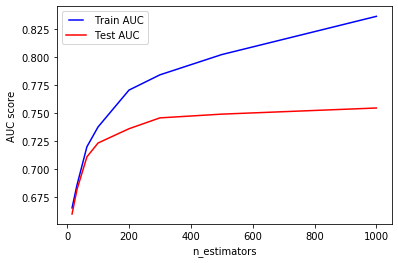

In [83]:
n_estimators = [16, 32, 64, 100, 200, 300, 500, 1000]
train_results = []
test_results = []

for estimator in n_estimators:
    model = GradientBoostingClassifier(n_estimators=estimator)
    model.fit(X_train, y_train)
    
    train_pred = model.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    
    y_pred = model.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(n_estimators, train_results, 'b', label='Train AUC')
line2, = plt.plot(n_estimators, test_results, 'r', label='Test AUC')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.savefig('figures/estimators.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

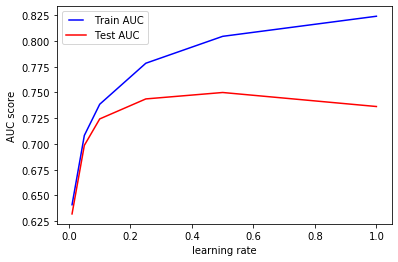

In [77]:
learning_rates = [1, 0.5, 0.25, 0.1, 0.05, 0.01]
train_results = []
test_results = []

for eta in learning_rates:
    model = GradientBoostingClassifier(learning_rate=eta)
    model.fit(X_train, y_train)
    
    train_pred = model.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    
    y_pred = model.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(learning_rates, train_results, 'b', label='Train AUC')
line2, = plt.plot(learning_rates, test_results, 'r', label='Test AUC')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('learning rate')
plt.savefig('figures/learningrate.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

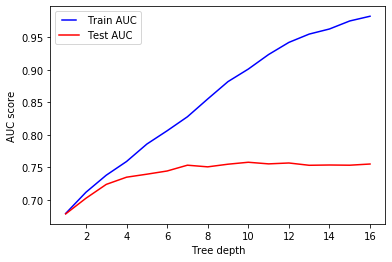

In [82]:
max_depths = np.linspace(1, 16, 16, endpoint=True)
train_results = []
test_results = []

for max_depth in max_depths:
    model = GradientBoostingClassifier(max_depth=max_depth)
    model.fit(X_train, y_train)
    
    train_pred = model.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    
    y_pred = model.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, test_results, 'r', label='Test AUC')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.savefig('figures/treedepth.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

Using the following parameters:
- `n_estimators= 300`
- `learning_rate = 0.50`
- `max_depth = 7`

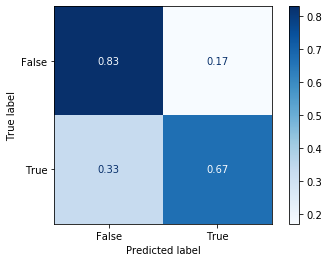

In [283]:
gb_clf2 = GradientBoostingClassifier(n_estimators=300, learning_rate=0.5, max_depth=7, random_state=0)
gb_clf2.fit(X_train, y_train)

y_pred = gb_clf2.predict(X_test)

metrics.plot_confusion_matrix(gb_clf2, X_test, y_test, cmap=plt.cm.Blues, normalize = 'true')

In [284]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.78      0.83      0.81      4126
        True       0.73      0.67      0.70      2865

    accuracy                           0.76      6991
   macro avg       0.76      0.75      0.75      6991
weighted avg       0.76      0.76      0.76      6991



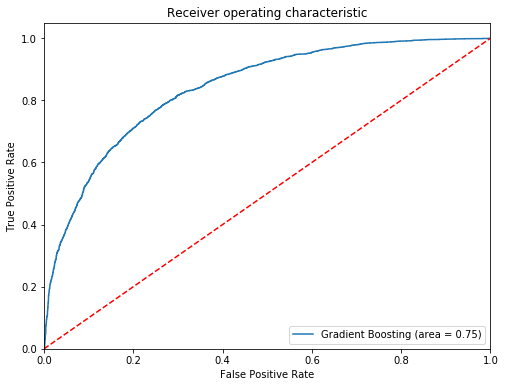

In [285]:
logit_roc_auc = roc_auc_score(y_test, gb_clf2.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, gb_clf2.predict_proba(X_test)[:,1])

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='Gradient Boosting (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('figures/ROC.png', dpi=300, bbox_inches='tight')
plt.show()

Without ordered protocols:
- `n = 113556 with 123364 visits (AUROC = 0.71)`

With ordered protocols:
- ` n = 21887 with 23301 visits (AUROC = 0.75)`
    - `Caucasian           17206`
    - `African American     2427`
    - `Hispanic             2149`
    - `Other/Unknown        1083`
    - `Asian                 338`
    - `Native American        98`
- `Trauma subset (n = 972 with 1007 visits)`
    - `Caucasian           823`
    - `Other/Unknown        65`
    - `African American     53`
    - `Hispanic             43`
    - `Asian                18`
    - `Native American       5`


In [271]:
two_day = pts[pts.unitdischargeoffset >= 1440]

In [272]:
two_day.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19656 entries, 10375 to 200767
Data columns (total 31 columns):
patientunitstayid            19656 non-null int64
patienthealthsystemstayid    19656 non-null int64
gender                       19656 non-null object
age                          19656 non-null int64
ethnicity                    19656 non-null object
hospitalid                   19656 non-null int64
wardid                       19656 non-null int64
apacheadmissiondx            19656 non-null object
admissionheight              19656 non-null float64
hospitaladmitoffset          19656 non-null int64
hospitaladmitsource          19656 non-null object
hospitaldischargeoffset      19656 non-null int64
hospitaldischargelocation    19656 non-null object
hospitaldischargestatus      19656 non-null object
unittype                     19656 non-null object
unitadmitsource              19656 non-null object
unitvisitnumber              19656 non-null int64
unitstaytype              

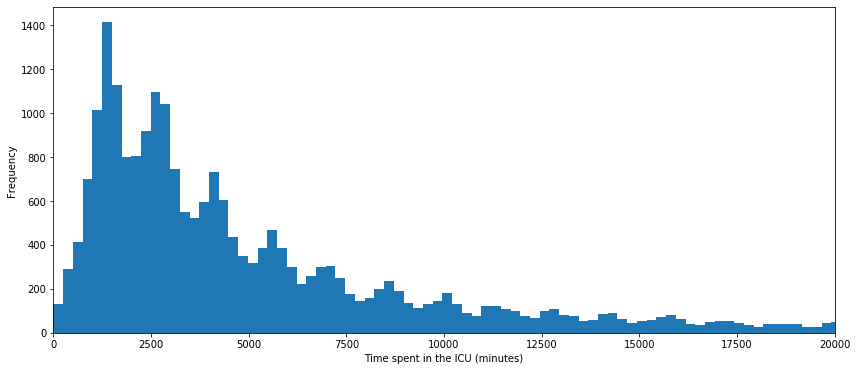

In [274]:
plt.figure(figsize=(14, 6))
pts.unitdischargeoffset.plot.hist(bins=2000)
plt.xlim([0.0, 20000.0])
plt.xlabel('Time spent in the ICU (minutes)')
plt.savefig('figures/ICUstay_dist.png', dpi=300, transparent=True, bbox_inches='tight')

In [212]:
pts.head()

,patientunitstayid,patienthealthsystemstayid,gender,age,ethnicity,hospitalid,wardid,apacheadmissiondx,admissionheight,hospitaladmitoffset,hospitaladmitsource,hospitaldischargeoffset,hospitaldischargelocation,hospitaldischargestatus,unittype,unitadmitsource,unitvisitnumber,unitstaytype,admissionweight,unitdischargeoffset,unitdischargelocation,unitdischargestatus,treatmentstring,painmeds,numbedscategory,teachingstatus,region,max_pain,mean_pain,icd9codes
0,141168,128919,Female,70,Caucasian,59,91,"Rhythm disturbance (atrial, supraventricular)",152.4,0,Direct Admit,3596,Death,Expired,Med-Surg ICU,Direct Admit,1,admit,84.3,3596,Death,Expired,no pain medications,False,<100,f,Midwest,0.0,0.0,"[414.00, I25.10, 491.20, J44.9, 491.20, J44.9,..."
6,141203,128948,Female,77,Caucasian,66,90,"Arrest, respiratory (without cardiac arrest)",160.0,-1336,Floor,4063,Other External,Alive,Med-Surg ICU,Floor,1,admit,70.2,1869,Floor,Alive,no pain medications,False,100 - 249,f,Midwest,6.0,2.0,"[518.82, 294.9, F03, 345.90, R56.9, 345.90, R5..."
8,141227,128968,Male,82,Caucasian,60,83,"Sepsis, pulmonary",185.4,-1004,Floor,1712,Other Hospital,Alive,Med-Surg ICU,Floor,1,admit,82.2,1652,Other Hospital,Alive,no pain medications,False,<100,f,Midwest,4.0,1.0,"[038.9, A41.9]"
9,141229,128970,Female,90,Caucasian,63,95,"CHF, congestive heart failure",160.0,-4,Emergency Department,3499,Skilled Nursing Facility,Alive,Med-Surg ICU,Emergency Department,1,admit,89.8,166,Floor,Alive,no pain medications,False,100 - 249,f,Midwest,4.0,1.0,"[427.31, I48.0, 428.1, I50.1, 428.0, I50.9, 78..."
16,141266,129000,Male,73,Caucasian,71,113,"Sepsis, renal/UTI (including bladder)",188.0,-18,Emergency Department,11148,Home,Alive,Med-Surg ICU,Emergency Department,1,admit,120.4,1501,Floor,Alive,no pain medications,False,100 - 249,f,Midwest,0.0,0.0,"[456.0, I85.01, 584.9, N17.9, 595.9, N30.9, 42..."


In [258]:
trauma = pts[pts['apacheadmissiondx'].str.contains('trauma', case = True)]

In [259]:
trauma.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1007 entries, 15191 to 200411
Data columns (total 31 columns):
patientunitstayid            1007 non-null int64
patienthealthsystemstayid    1007 non-null int64
gender                       1007 non-null object
age                          1007 non-null int64
ethnicity                    1007 non-null object
hospitalid                   1007 non-null int64
wardid                       1007 non-null int64
apacheadmissiondx            1007 non-null object
admissionheight              1007 non-null float64
hospitaladmitoffset          1007 non-null int64
hospitaladmitsource          1007 non-null object
hospitaldischargeoffset      1007 non-null int64
hospitaldischargelocation    1007 non-null object
hospitaldischargestatus      1007 non-null object
unittype                     1007 non-null object
unitadmitsource              1007 non-null object
unitvisitnumber              1007 non-null int64
unitstaytype                 1007 non-null o